In [1]:
from __future__ import division
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Lambda, Reshape
from keras import backend as K
from keras.optimizers import SGD, Nadam
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import os

Using TensorFlow backend.


In [2]:
DATA_DIR = os.path.abspath('./')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights.hdf5')
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_base.hdf5')
EXPERIENCE_BUFFER_FILE = os.path.join(DATA_DIR, 'experience_buffer.p')

In [179]:
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2, l1
from keras.initializers import VarianceScaling

kernel_initializer = VarianceScaling(scale=0.001, mode='fan_avg', distribution='uniform', seed=42)

def dense_relu_bn_dropout(x, size, dropout, activation='tanh', reg = 0):
    x = Dense(size, kernel_regularizer = l2(reg), kernel_initializer=kernel_initializer)(x)
    x = Activation(activation)(x)
    x = Dropout(dropout)(x)
    return x

def create_network(reg, dropout, activation = 'relu'):
    inputs = Input(shape=(INPUT_SHAPE,), name="x")
    x = dense_relu_bn_dropout(inputs, size=8 , activation=activation,
                              dropout=dropout, reg=reg)
    x = Dense(1, kernel_initializer=kernel_initializer)(x)
    base_network = Model(inputs=inputs, outputs = x)
    print(base_network.summary())
    return base_network

In [198]:
INPUT_SHAPE = 8
base_network = create_network(activation='selu', reg = 0, dropout = 0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 8)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 72        
_________________________________________________________________
activation_23 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None


In [199]:
BASE_WEIGHTS = base_network.get_weights()
for i in xrange(len(BASE_WEIGHTS)):
    if i == 0:
        BASE_WEIGHTS[i][:2, 0] = 1
    elif i == 2:
        BASE_WEIGHTS[i][0,0] = 1

In [200]:
base_network.set_weights(BASE_WEIGHTS)
base_network.get_weights()

[array([[  1.00000000e+00,   6.87097199e-03,   1.14376266e-02,
           9.90638509e-03,  -9.31235030e-04,   5.07418253e-03,
          -1.21603794e-02,  -1.49377976e-02],
        [  1.00000000e+00,   8.64972919e-03,  -1.08753508e-02,
           1.38396267e-02,   1.25453826e-02,   3.69531848e-03,
          -1.92501731e-02,  -9.78878234e-03],
        [  2.35248357e-04,  -5.36064617e-03,  -1.76283326e-02,
           1.82869155e-02,   1.27184298e-02,  -3.30814533e-03,
           3.93750705e-03,  -6.21277466e-03],
        [  2.83125602e-03,  -1.02147805e-02,   6.76937588e-03,
          -1.90814082e-02,  -1.85549743e-02,   1.78885218e-02,
           5.20928390e-03,  -1.06005678e-02],
        [  5.86896390e-03,   1.42149385e-02,  -9.50662699e-03,
          -8.80788267e-03,  -1.36415288e-03,  -8.05000495e-03,
          -1.12284468e-02,  -2.86217965e-03],
        [  1.67792682e-02,  -3.19867395e-03,   8.32178630e-03,
           2.56576203e-03,  -7.71657284e-03,   1.35459248e-02,
          -1.8

In [201]:
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, Lambda, Reshape

input_a = Input(shape=(INPUT_SHAPE,))
processed_a = base_network(input_a)
input_b = Input(shape=(INPUT_SHAPE,))
processed_b = base_network(input_b)
distance = layers.Subtract()([processed_a, processed_b])
out = Activation('sigmoid')(distance)
siamese_net = Model([input_a, input_b], out)
siamese_net.save_weights(INIT_WEIGHTS)
print(siamese_net.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 8)             0                                            
____________________________________________________________________________________________________
input_16 (InputLayer)            (None, 8)             0                                            
____________________________________________________________________________________________________
model_21 (Model)                 (None, 1)             81          input_15[0][0]                   
                                                                   input_16[0][0]                   
____________________________________________________________________________________________________
subtract_8 (Subtract)            (None, 1)             0           model_21[1][0]          

In [202]:
import cPickle as pickle
MOVES = pickle.load(open("../moves_dict.p", "rb"))

In [215]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
              patience=4, verbose = 1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=1e-3,
                              patience=15,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='val_acc')

In [212]:
import utils; reload(utils)
from utils import DataGenerator

BATCH_SIZE = 1024
maxlen = 4
EXPERIENCE_BUFFER_FILE = "experience_buffer/experience_buffer_len{}.p".format(maxlen) 
load_from_file = False #os.path.exists(EXPERIENCE_BUFFER_FILE)
save_to_file = not load_from_file
datagen = DataGenerator(MOVES, batch_sz = BATCH_SIZE, load_from_file = load_from_file, 
                 save_to_file = save_to_file, maxlen = maxlen, file = EXPERIENCE_BUFFER_FILE)

Experience buffer generated
Experience buffer saved to experience_buffer/experience_buffer_len4.p
Train: 1464961 Val: 61041


In [216]:
nadam = Nadam(lr=1e-3)
siamese_net.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
siamese_net.load_weights(INIT_WEIGHTS)

In [217]:
NUM_TRAIN_PAIRS, NUM_VAL_PAIRS = datagen.get_num_pairs()
STEPS_PER_EPOCH = NUM_TRAIN_PAIRS//BATCH_SIZE
VALIDATION_STEPS = NUM_VAL_PAIRS//BATCH_SIZE

In [218]:
# siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
history = siamese_net.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=250,
        validation_data=datagen.next_val(),
        validation_steps=VALIDATION_STEPS,
        callbacks = [reduce_lr, checkpointer, early_stopping])

Epoch 1/250
1430/1430 [==============================] - 18s - loss: 1.2773 - acc: 0.6551 - val_loss: 0.5409 - val_acc: 0.7582
Epoch 2/250
1430/1430 [==============================] - 25s - loss: 0.5844 - acc: 0.7158 - val_loss: 0.5315 - val_acc: 0.7703
Epoch 3/250
1430/1430 [==============================] - 24s - loss: 0.5836 - acc: 0.7157 - val_loss: 0.5314 - val_acc: 0.7710
Epoch 4/250
1430/1430 [==============================] - 27s - loss: 0.5825 - acc: 0.7156 - val_loss: 0.5277 - val_acc: 0.7702
Epoch 5/250
1430/1430 [==============================] - 24s - loss: 0.5824 - acc: 0.7155 - val_loss: 0.5292 - val_acc: 0.7694
Epoch 6/250
1430/1430 [==============================] - 26s - loss: 0.5818 - acc: 0.7153 - val_loss: 0.5284 - val_acc: 0.7716
Epoch 7/250
1430/1430 [==============================] - 25s - loss: 0.5816 - acc: 0.7148 - val_loss: 0.5295 - val_acc: 0.7693
Epoch 8/250
1430/1430 [==============================] - 26s - loss: 0.5805 - acc: 0.7154 - val_loss: 0.5262 - 

1430/1430 [==============================] - 12s - loss: 0.5749 - acc: 0.7202 - val_loss: 0.5224 - val_acc: 0.7702
Epoch 30/250
1430/1430 [==============================] - 12s - loss: 0.5745 - acc: 0.7211 - val_loss: 0.5214 - val_acc: 0.7710
Epoch 31/250
1430/1430 [==============================] - 12s - loss: 0.5746 - acc: 0.7206 - val_loss: 0.5207 - val_acc: 0.7704
Epoch 32/250
1423/1430 [============================>.] - ETA: 0s - loss: 0.5747 - acc: 0.7201
Epoch 00031: reducing learning rate to 6.25000029686e-05.
Epoch 00031: val_acc did not improve
1430/1430 [==============================] - 12s - loss: 0.5747 - acc: 0.7201 - val_loss: 0.5215 - val_acc: 0.7701
Epoch 33/250
1430/1430 [==============================] - 12s - loss: 0.5748 - acc: 0.7204 - val_loss: 0.5212 - val_acc: 0.7705
Epoch 34/250
1430/1430 [==============================] - 12s - loss: 0.5743 - acc: 0.7205 - val_loss: 0.5208 - val_acc: 0.7709
Epoch 35/250
1430/1430 [==============================] - 12s - loss

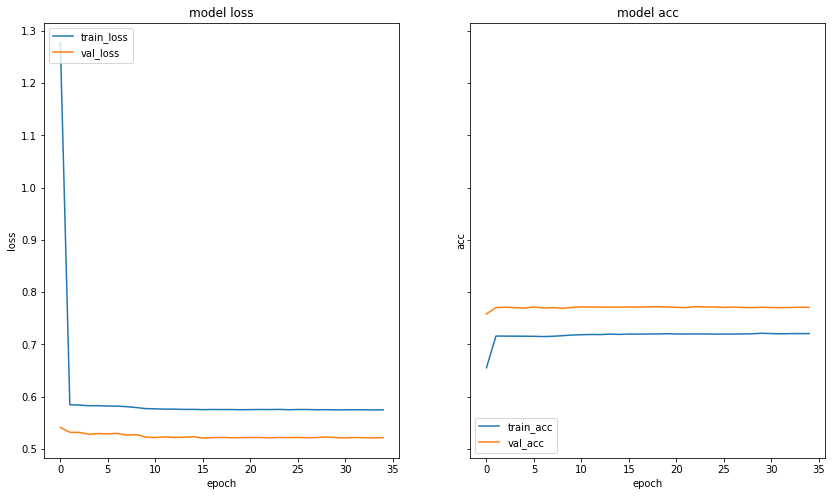

In [219]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(14)

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train_loss', 'val_loss'], loc='upper left')

ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
ax2.set_title('model acc')
ax2.set_ylabel('acc')
ax2.set_xlabel('epoch')
ax2.legend(['train_acc', 'val_acc'], loc='lower left')

plt.show()

In [220]:
for i in range(2):
    if i == 0:
        print("Base weights:")
        siamese_net.set_weights(BASE_WEIGHTS)
    else:
        print("Checkpointed weights:")
        siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
    val = siamese_net.evaluate_generator(
            datagen.next_train(),
            steps=STEPS_PER_EPOCH)
    print("Loss: {} Acc: {}".format(val[0], val[1]))

Base weights:
Loss: 0.866059393765 Acc: 0.777433728352
Checkpointed weights:
Loss: 0.521243631092 Acc: 0.770315935715


In [221]:
# siamese_net.set_weights(BASE_WEIGHTS)
siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
SAVE_MODEL = "keras_tensorflow"
model_to_save = siamese_net.layers[2]
model_to_save.summary()
model_to_save.save(SAVE_MODEL, overwrite='True')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 8)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 72        
_________________________________________________________________
activation_23 (Activation)   (None, 8)                 0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [222]:
model_to_save.get_weights()

[array([[  9.31617543e-02,   6.28616884e-02,   6.34780750e-02,
           6.31450415e-02,  -7.23109469e-02,   6.20519184e-02,
          -7.01870769e-02,  -7.26490691e-02],
        [  1.00306980e-01,   2.71187127e-02,   2.63463594e-02,
           2.60378812e-02,  -9.34500918e-02,   2.53457744e-02,
          -9.40271765e-02,  -9.67363417e-02],
        [  1.05681620e-03,   6.32985553e-04,   9.75474075e-04,
           9.69368266e-04,   7.25866761e-04,   9.12884832e-04,
           9.65720508e-04,   1.36871787e-03],
        [ -2.28267466e-03,   3.03111970e-02,   3.38098556e-02,
           3.12345773e-02,   3.72106805e-02,   2.91743632e-02,
           4.13598046e-02,   4.13997732e-02],
        [  8.82115774e-03,   4.54497635e-02,   5.27618490e-02,
           5.05710617e-02,   5.59164844e-02,   4.85748723e-02,
           4.80583198e-02,   4.81603220e-02],
        [ -5.40936030e-02,   2.33633500e-02,   2.44849846e-02,
           1.94505006e-02,   4.33787555e-02,   2.68147942e-02,
           4.3

In [223]:
status = os.system("python keras_to_tensorflow.py keras_tensorflow")
if status == 0:
    print("Success")

Success
